#### Delta Hedging

In [ ]:
# fazer as trajetórias do ativo ao longo do tempo
## gerar um movimento browniano geométrico para isso 
## ao longo de 1 até T

# calcular o PnL ao longo do tempo

# calcular o valor da call ao longo do tempo
## acredito que deve ter que calcular V(t_i, T)

# calcular o delta hedging ao longo do tempo

# juntar essas informações em um gráfico

# fazer isso para os cenários (ITM, OTM e ATM)

# ref: pag 76 cornelis

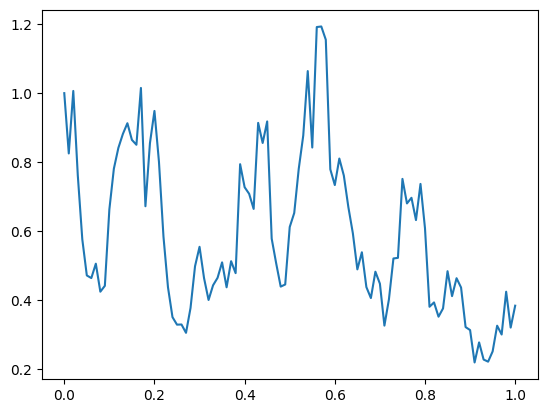

In [23]:
import numpy as np
import matplotlib.pyplot as plt

sigma = 2
mu = 0
r = 0.1
S_0 = 1
T = 1
K = 0.95
n=100

def gbm(S0, r, sigma, T, M, I):
    dt = float(T) / M
    paths = np.zeros((M + 1, I), np.float64)
    paths[0] = S0
    for t in range(1, M + 1):
        rand = np.random.standard_normal()
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt +
                                         sigma * np.sqrt(dt) * rand)
    return paths

x = np.linspace(0,T,n+1)
y = [x for x in gbm(S0=S_0, r=mu, sigma=sigma, T=T, M=n, I=1)]

fig, ax = plt.subplots()

ax.plot(x,y)

plt.show()

In [ ]:
# fazer 1000 simulações de delta hedging calculando o PnL com rebalanceamto em 10 vezes

# fazer 1000 simulações de delta hedging calculando o PnL com rebalanceamto em 2000 vezes

#### funcionamento do GPR

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros
S0 = 100  # Preço inicial
mu = r = 0.1  # Taxa de retorno esperada
sigma = 0.2  # Volatilidade
T = 2  # Horizonte de tempo (anos)
N = 3  # Número de passos (aprox. número de dias úteis em um ano)

def gbm(T, N, mu, sigma):
    
    dt = T / N  # Incremento de tempo
    
    # Inicialização dos vetores de tempo e preço
    t = np.linspace(0, T, N)
    S = np.ones(N)
    S[0] = S0

    # Simulação do GBM
    for i in range(0, N):
        Z = np.random.normal()
        S[i] = S[i-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

    return np.array(S)

In [2]:
tamanho_amostra = 2*10**4
numero_ativos = 1
numero_tempo = 10

X = np.array([gbm(2, numero_tempo, mu, sigma) for i in range(tamanho_amostra*numero_ativos)])
# X = X.reshape(numero_ativos*tamanho_amostra, numero_tempo)
X.shape


(20000, 10)

In [15]:
import numpy as np

def f(X, K):
    X_max = max(X)

    call = X_max - K
    return call if call > 0 else 0


n_ativos = 5
n_passos = 10
X = np.random.normal(size=(n_ativos, n_passos))
S = np.array([gbm(2, n_passos, mu, sigma) for i in range(n_ativos)])

max_call = np.array([f(S[:,i], 1) for i in range(S.shape[1])])


X_train = S
y_train = max_call

X_train.shape

(5, 10)

In [14]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

# --------------------------------------
# Passo 1: Geração de dados de exemplo
# --------------------------------------
np.random.seed(42)
n_samples = 20
d = 6


X_train = S
y_train = max_call

# Exemplo de função alvo y_j = (|I_j|^{1/2} * g_j) / sqrt(w_j)


# --------------------------------------
# Passo 2: Definição do kernel e GPR
# --------------------------------------
# Limites dos hiperparâmetros
alpha_bounds = (2.8e-5, 83.0)     # bound para ConstantKernel
beta_bounds  = (1e-9, 0.15)       # bound para RBF length_scale
lambda_bounds = (1e-12, 1e-3)     # bound para WhiteKernel noise_level

# Kernel = Constant * RBF + WhiteKernel
kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=alpha_bounds) 
    * RBF(length_scale=1.0, length_scale_bounds=beta_bounds)
    + WhiteKernel(noise_level=1e-5, noise_level_bounds=lambda_bounds)
)

# Instância do regressor gaussiano
gpr = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=10,
    normalize_y=True
)

# Treinamento do modelo GPR
gpr.fit(X_train, y_train)

# Exibir o kernel ajustado e valor da log-marginal likelihood
print("Kernel ajustado:", gpr.kernel_)
print("Log-marginal likelihood:", gpr.log_marginal_likelihood(gpr.kernel_.theta))


# --------------------------------------
# Passo 3: Teste do modelo e predições
# --------------------------------------
n_test = 200
numero_ativos = 1
numero_tempo = 10

n_ativos = 5
n_passos = 10
X = np.random.normal(size=(n_ativos, n_passos))
S = np.array([gbm(2, n_passos, mu, sigma) for i in range(n_ativos)])

max_call = np.array([f(S[:,i], 1) for i in range(S.shape[1])])

X_test = S

# Predição via GPR: retorna média e desvio padrão
y_pred, y_std = gpr.predict(X_test, return_std=True)

# Exibir amostras de predição
for i in range(4):
    print(f"X_test[{i}] = {X_test[i]}, y_pred = {y_pred[i]:}, y_std = {y_std[i]:}")


ValueError: Found input variables with inconsistent numbers of samples: [5, 10]